In [18]:
### General imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

### CNN models ###
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2#, activity_l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers

### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle

# 1. Define the model architecture

In [19]:
path = '../Data/'
local_path = '../Data/'

In [20]:
X_train = np.load(local_path + "X_train.npy")
X_test = np.load(local_path + "X_test.npy")
y_train = np.load(local_path + "y_train.npy")
y_test = np.load(local_path + "y_test.npy")

In [21]:
shape_x = 48
shape_y = 48
nRows, nCols, nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)
classes = np.unique(y_train)
nClasses = len(classes)

In [22]:
def entry_flow(inputs) :
    
    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, 3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    previous_block_activation = x
    
    for size in [128, 256, 728] :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        
        x = keras.layers.Add()([x, residual])
        previous_block_activation = x
    
    return x

def middle_flow(x, num_blocks=8) :
    
    previous_block_activation = x
    
    for _ in range(num_blocks) :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    
    return x

def exit_flow(x, num_classes=7) :
    
    previous_block_activation = x
    
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = keras.layers.Add()([x, residual])
      
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    return x

In [23]:
inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))

In [24]:
xception = Model(inputs, outputs)

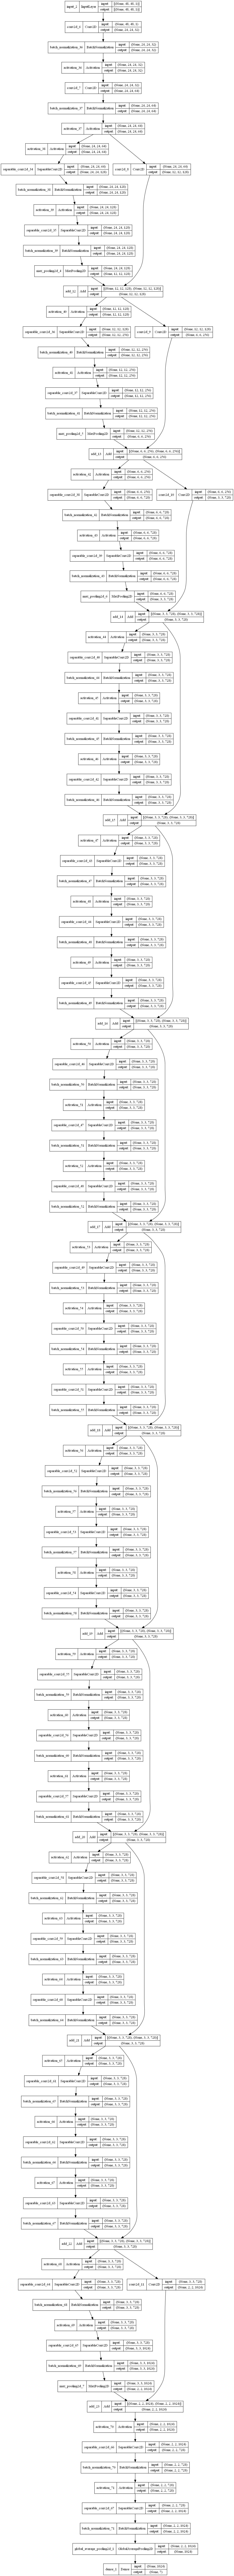

In [25]:
plot_model(xception, show_shapes=True, show_layer_names=True)

# 2. Vizualize layers

In [36]:
def detect_face(frame):
    
    #Cascade classifier pre-trained model
    cascPath = '../Data/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)
    
    #BGR -> Gray conversion
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #Cascade MultiScale classifier
    detected_faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=6,
                                                  minSize=(shape_x, shape_y),
                                                  flags=cv2.CASCADE_SCALE_IMAGE)
    coord = []
    
    for x, y, w, h in detected_faces :
        if w > 100 :
            sub_img=frame[y:y+h,x:x+w]
            coord.append([x,y,w,h])
    
    return gray, detected_faces, coord

def extract_face_features(faces, offset_coefficients=(0.075, 0.05)):
    gray = faces[0]
    detected_face = faces[1]
    
    new_face = []
    
    for det in detected_face :
        x, y, w, h = det
        horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
        vertical_offset = np.int(np.floor(offset_coefficients[1] * h))

        extracted_face = gray[y + vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
    
        new_extracted_face = zoom(extracted_face, (shape_x / extracted_face.shape[0],shape_y / extracted_face.shape[1]))
        new_extracted_face = new_extracted_face.astype(np.float32)
        new_extracted_face /= float(new_extracted_face.max())
    
        new_face.append(new_extracted_face)
    
    return new_face

In [37]:
layer_outputs = [layer.output for layer in xception.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=xception.input, outputs=layer_outputs)

In [38]:
layer_names = []
for layer in xception.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

In [40]:
image_path = '../Data/image.jpg'
image = cv2.imread(image_path)
face = extract_face_features(detect_face(image))[0]

to_predict = np.reshape(face.flatten(), (1,48,48,1))
res = xception.predict(to_predict)
activations = activation_model.predict(to_predict)

<ipython-input-36-d7ead4832a95>:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
<ipython-input-36-d7ead4832a95>:32: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.

In [42]:
res

array([[0.14285655, 0.14285713, 0.14285551, 0.14285776, 0.14285728,
        0.1428574 , 0.14285831]], dtype=float32)

<ipython-input-41-f6578ff0825d>:21: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(display_grid, aspect='auto', cmap='viridis')
<ipython-input-41-f6578ff0825d>:10: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\tight_bbox.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\tight_bbox.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\patches.py:781: RuntimeWarning: invalid value encountered in double_scalars
  self._y1 = self._y0 + self._height
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\transforms.py:1978: RuntimeWarning: invalid value encountered in double_scal

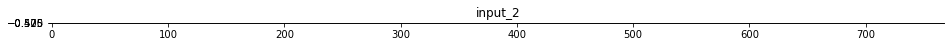

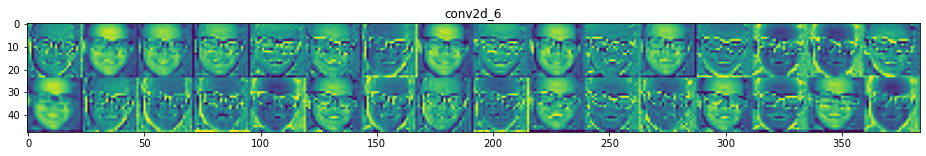

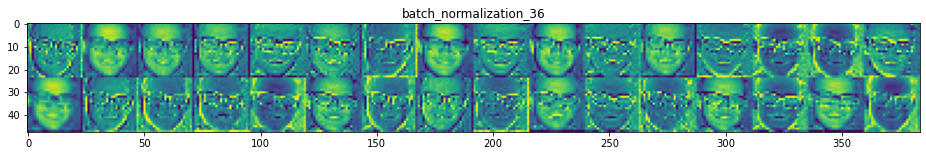

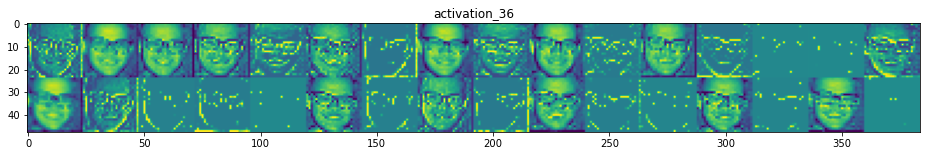

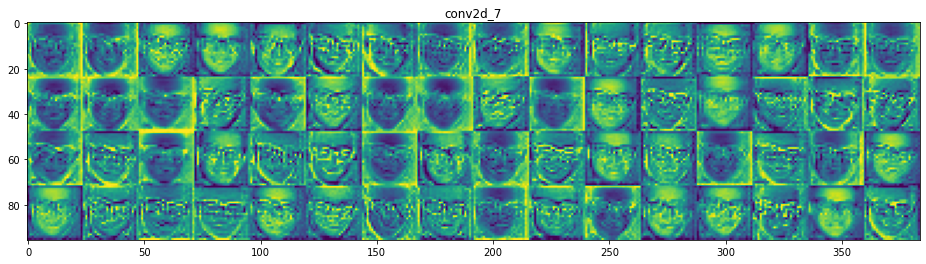

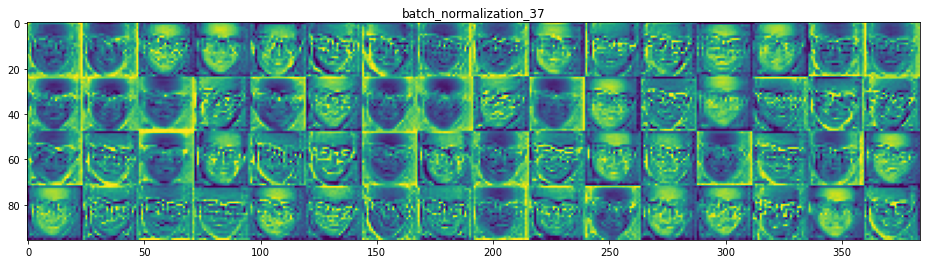

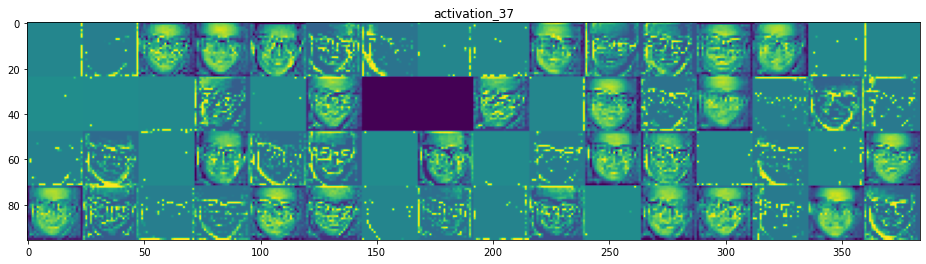

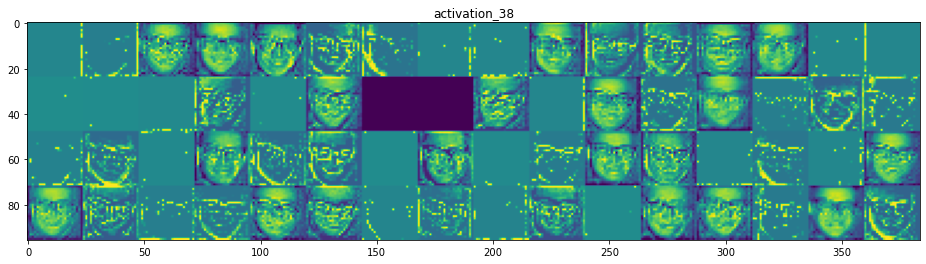

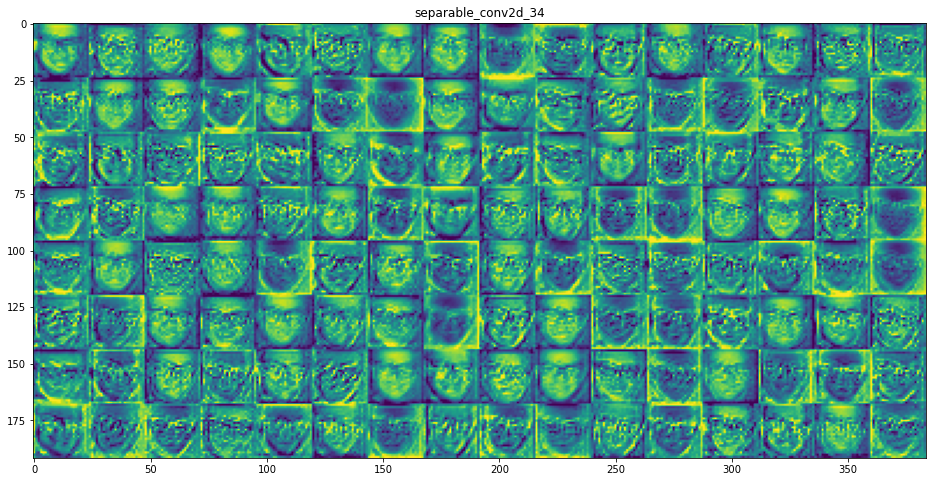

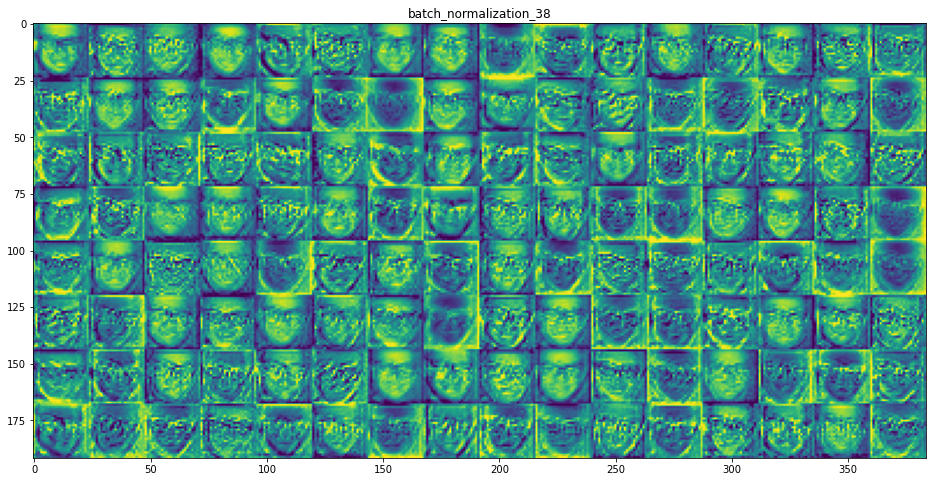

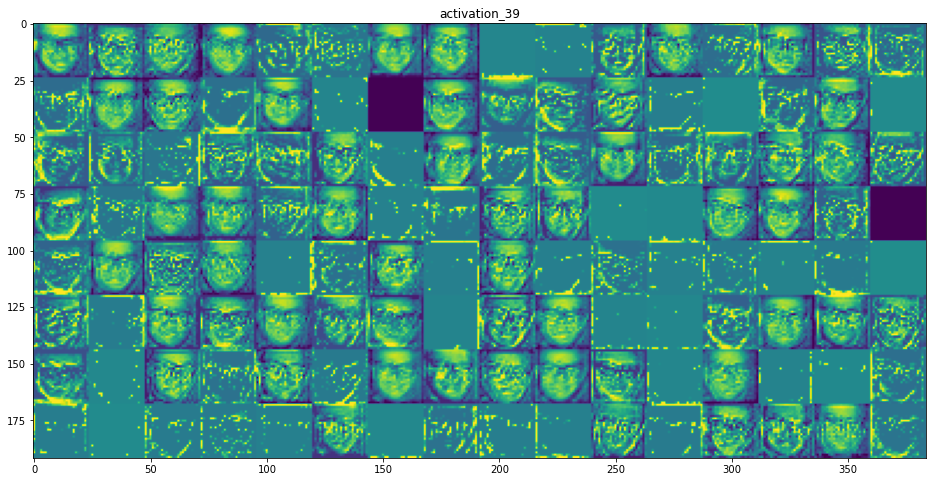

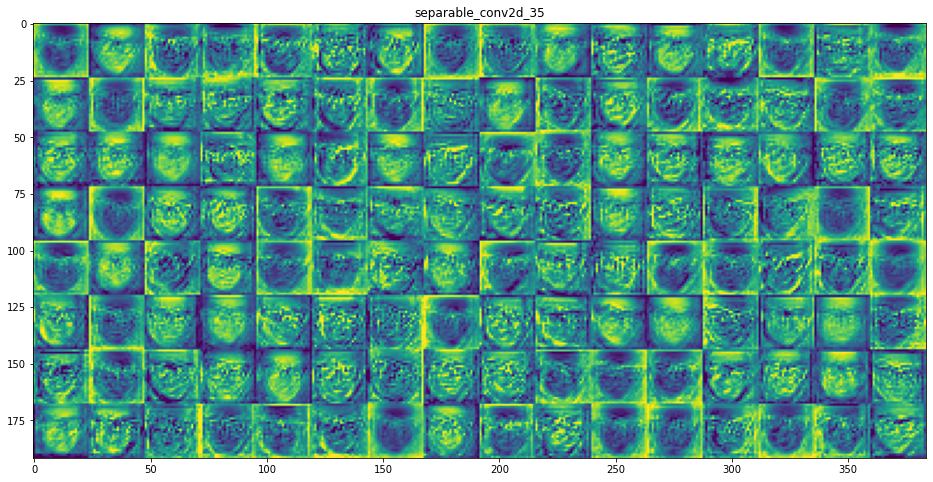

In [41]:
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# 3. Train model

In [26]:
xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 128
epochs = 150

In [17]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

history = xception.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs, 
    validation_data=(X_test, y_test)
)

<ipython-input-17-e5f7a64ee7c3>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = xception.fit_generator(


Epoch 1/150
 37/225 [===>..........................] - ETA: 23s - loss: 1.8289 - accuracy: 0.2739

KeyboardInterrupt: 

# 4. Save model

In [ ]:
#save the model weights
json_string = xception.to_json()
xception.save(local_path + 'xception.h5')
open(local_path + 'xception.json', 'w').write(json_string)
model.save_weights(local_path + 'xception_weights.h5')